##Initialization

In [29]:
!git clone https://github.com/xxBLUECATxx/Face-Drawing.git

%cd Face-Drawing

!wget https://huggingface.co/XBLUECATX/shape_predictor_68_face_landmarks/resolve/main/shape_predictor_68_face_landmarks.dat

Cloning into 'Face-Drawing'...
remote: Enumerating objects: 566, done.
^C
[Errno 2] No such file or directory: 'Face-Drawing'
/content/Face-Drawing
--2024-06-07 03:35:42--  https://huggingface.co/XBLUECATX/shape_predictor_68_face_landmarks/resolve/main/shape_predictor_68_face_landmarks.dat
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.88, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/63/9b/639b2b6105060482ae63a7278ae23aa2d448592e5147314eb14971595328b86f/fbdc2cb80eb9aa7a758672cbfdda32ba6300efe9b6e6c7a299ff7e736b11b92f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27shape_predictor_68_face_landmarks.dat%3B+filename%3D%22shape_predictor_68_face_landmarks.dat%22%3B&Expires=1717990542&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzk5MDU0Mn19LCJSZXNvd

In [30]:
import random, os, sys, subprocess, time, shutil
import cv2
import dlib
import numpy as np

# from mask_generator import make_mask


detector = dlib.get_frontal_face_detector()
PREDICTOR_PATH = "./shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)



def get_random_mask(masks, not_used, unique):
    # someone wants to explain random seed to me?
    # tried various weird things like random.seed(int(time.time()))
    # here without real success
    # problem is when going through a folder of images
    # the first mask will often (?) be the same
    # or is it just me ????????
    chosen = ""
    names = [m for m in masks]
    not_used_names = [m for m in not_used]
    if unique == True:
        if len(not_used_names) == 0:
            front = None
            back = None
            chosen = None
            # print "used all masks"
        else:
            ran = random.choice(not_used_names)
            front = get_img(  masks[ran]["front"] , mask=True )
            back = get_img(  masks[ran]["back"] )
            not_used.pop(ran, None)
            chosen = ran
    else:
        ran = random.choice(names)
        front = get_img(  masks[ran]["front"] , mask=True )
        back = get_img(  masks[ran]["back"] )
        chosen = ran
    return chosen, front, back, not_used

def add_alpha_channel(img):
    # img = cv2.imread(path)
    b_channel, g_channel, r_channel = cv2.split(img)
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 255 #creating a dummy alpha channel image.
    return cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

def remove_alpha_channel(img):
    return img[:,:,:3]

def get_img(path, mask=False):
    if mask:
        return cv2.imread(path, cv2.IMREAD_UNCHANGED)
    else:
        return cv2.imread(path)

def get_rects(img):
    rects = detector(img)
    return rects

def get_landmarks(img, rect):
    return np.matrix([[p.x, p.y] for p in predictor(img, rect).parts()])
# https://matthewearl.github.io/2015/07/28/switching-eds-with-python/

def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def warp_im(im, M, dshape):
    output_im = np.ones(dshape, dtype=im.dtype)*0
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def align_mask_img(ldmks, img, mask_ldmks, mask_img):
    transformation_matrix = transformation_from_points(ldmks, mask_ldmks)
    return warp_im(mask_img, transformation_matrix, img.shape)

def sort_faces_by_size(faces):
    pairs = list()
    for face in faces:
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y
        pairs.append([face, w*h])
    pairs.sort(key=lambda x: x[1])
    return [f[0] for f in pairs]

def assert_dir(dir_path):
    potential_out_dir = dir_path
    idx = -1
    while os.path.isdir(potential_out_dir):
        idx += 1
        if idx == 0:
            potential_out_dir += "_0"
            continue
        potential_out_dir = "_".join( potential_out_dir.split("_")[:-1] ) +  "_" + str(idx)
    out_dir = potential_out_dir
    os.mkdir(out_dir)
    print ("[+] Created " + out_dir + ". and will save output to that directory")
    return out_dir

def apply_masks(input_paths, masks, output_paths, apply_unique_masks, is_video):

    print ("[+] Applying mask(s)" )
    for j, path in enumerate(input_paths, 0):
        print ("\n\t[+] Opening", path)
        img = get_img(path)

        # find all faces
        faces = get_rects(img)
        if len(faces) == 0:
            print ("\t[-] no faces found")
            if is_video == True:
                temp_dir = "/".join( path.split("/")[:-1])
                f = path.split("/")[-1]
                temp_out = temp_dir + "_masked"
                if not os.path.isdir(temp_out):
                    os.mkdir(temp_out)
                output_path = os.path.join( temp_out, f)
                output_path = output_path.replace(".jpg", ".png")
                print ("\t[+] Saving as", output_path)
                cv2.imwrite(output_path, img)
            continue
        print ("\t[+] Found", len(faces), "faces")
        out = img.copy()

        #sort faces by size, start with the smallest
        faces = sort_faces_by_size(faces)

        masks_not_used = masks.copy()
       # print ("\t[+] faces:", len(faces), "masks:", len(masks), "unique:", apply_unique_masks)
        for i, face in enumerate(faces, 0):
            print ("\t\t[face " + str(i+1) + "]"),
            # pick a random mask, check if unique mask was selected
            mask_name, mask_front, mask_back, masks_not_used = get_random_mask(masks, masks_not_used, apply_unique_masks)
            if mask_name == None:
                print ("already used all masks once (you specified '-u' unique mask use)")
                continue

            print ("picked mask", mask_name)
            mask_face = get_rects(mask_back)[0]

            #get landmarks
            img = remove_alpha_channel(img)
            face_ldmks = get_landmarks(img, face)
            mask_ldmks = get_landmarks(mask_back, mask_face)

            # # align mask to face
            img = add_alpha_channel(img)
            aligned_mask = align_mask_img(face_ldmks, img, mask_ldmks, mask_front)

            x_offset=y_offset=0
            try:
                for c in range(0,3):
                    out[0:out.shape[0],0:out.shape[1], c] =  aligned_mask[:,:,c] * (aligned_mask[:,:,3]/255.0) +  out[0:out.shape[0], 0:out.shape[1], c] * (1.0 - aligned_mask[:,:,3]/255.0)
            except Exception as e:
                print (e)
                pass
        print ("\t[+] out :", out)
        cv2.imwrite('test/output.png', out)
        if not is_video:
            temp_dir = "/".join( path.split("\\")[:-1])
            f = path.split("\\")[-1]
            print(f, "fffffffffffffff")
            temp_out = f[:-4]+ "_masked"
            print ("\t[+] Saving as", output_paths[j] )
            cv2.imwrite(f'test/{temp_out}.png', out)
        else:
            temp_dir = "/".join( path.split("/")[:-1])
            f = path.split("/")[-1]
            temp_out = temp_dir + "_masked"
            if not os.path.isdir(temp_out):
                os.mkdir(temp_out)
            output_path = os.path.join( temp_out, f)
            print( "\t[+] Saving as", output_path)
            cv2.imwrite(output_path, out)

    if is_video == True:
        temp_dir = "/".join( path.split("/")[:-1])
        f = path.split("/")[-1]
        temp_out = temp_dir + "_masked"

        print( "[+] Combining frames to video")
        print ("""
        This uses ffmpeg, which you hopefully have installed.
        Also not sound supported yet.... would be a few changes in the ffmpeg commands,
        but I thought it was fine for now.
        """)
        fps = '25'
        if os.path.isfile( os.path.join(temp_dir, "fps.txt")):
            fps = open( os.path.join( temp_dir, "fps.txt")).read().strip()

        subprocess.call(["ffmpeg", "-r", fps,  "-f", "image2", "-i",  os.path.join(temp_out, "frame%10d.jpg"), "-r", fps, os.path.join(temp_out, "video.mp4")  ])

        if os.path.isfile( os.path.join(temp_dir, "sound.aac")):

            subprocess.call(["ffmpeg",  "-i", os.path.join(temp_out,"video.mp4"), "-i",  os.path.join(temp_dir, "sound.aac"), "-c:v", "copy", "-c:a", "aac", "-strict", "experimental", "-r", fps, output_paths[0]  ])
        else:
            shutil.move( os.path.join(temp_out, "video.mp4"), output_paths[0])
        print ("\t[+] Cleaning up after myself")

        shutil.rmtree(temp_dir)
        shutil.rmtree(temp_out)
        print ("\t[+] Saving as", output_paths[0])


## Face Drawing

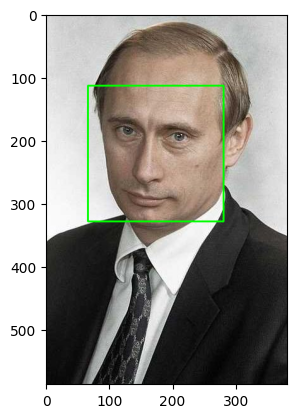

In [31]:
target = get_img("examples/faces/face2.jpg", )
face = get_rects(target)


#plot the original image with the rectangles
out = target.copy()
for rect in face:
    cv2.rectangle(out, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
#cv2.imwrite("test/face_rects.jpg", out)
#visualize the output
import matplotlib.pyplot as plt

out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

plt.imshow(out)



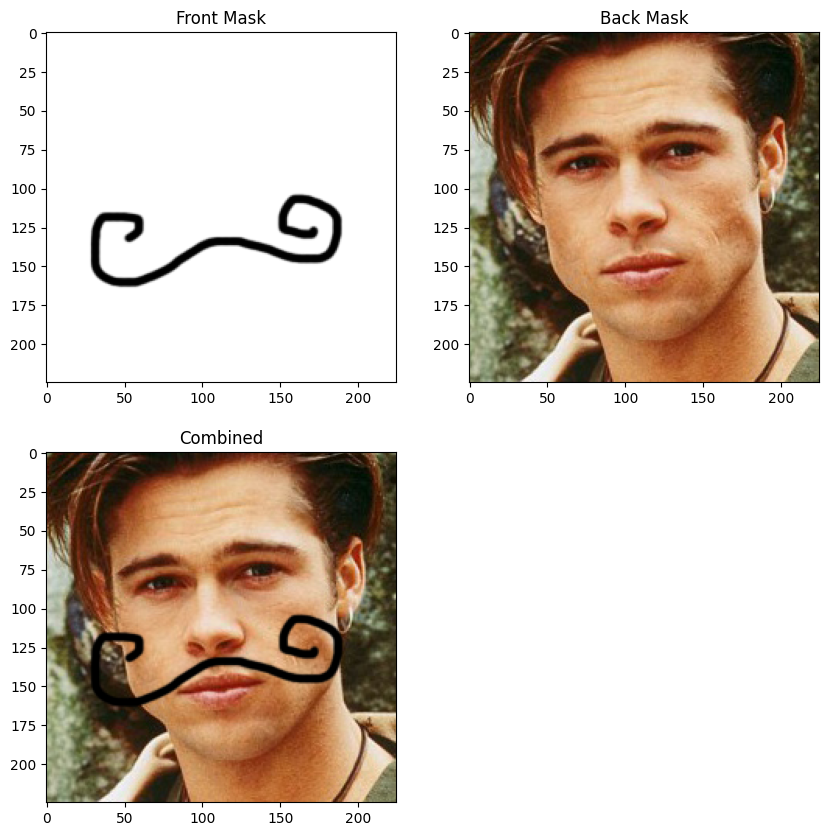

In [32]:
mask_front =  get_img('examples/masks/beard_front.png',mask=True)
mask_back = get_img('examples/masks/beard_back.png',mask = True)
mask_face = get_rects(mask_back)[0]


mask_back_show =mask_back.copy()
mask_back_show = cv2.cvtColor(mask_back_show, cv2.COLOR_BGR2RGB)

apply_unique_masks = False

out = mask_back.copy()
aligned_mask = mask_front.copy()

try:
    for c in range(0,3):
        out[0:out.shape[0],0:out.shape[1], c] =  aligned_mask[:,:,c] * (aligned_mask[:,:,3]/255.0) +  out[0:out.shape[0], 0:out.shape[1], c] * (1.0 - aligned_mask[:,:,3]/255.0)
except Exception as e:
    print (e)
    pass

out = cv2.cvtColor(out,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))  # Optional: Set the figure size

plt.subplot(2, 2, 1)  # Arguments are: (number of rows, number of columns, index of current plot)
plt.imshow(mask_front)
plt.title('Front Mask')  # Optional: Set the title for the plot

plt.subplot(2, 2, 2)
plt.imshow(mask_back_show)
plt.title('Back Mask')  # Optional: Set the title for the plot

plt.subplot(2, 2, 3)
plt.imshow(out)
plt.title('Combined')

plt.show()

Text(0.5, 1.0, 'Target Face')

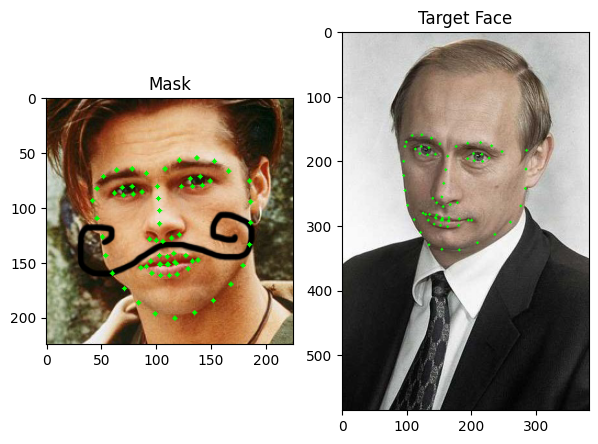

In [33]:
face = sort_faces_by_size(face)
target = remove_alpha_channel(target)
face_ldmks = get_landmarks(target, face[0])
mask_ldmks = get_landmarks(mask_back, mask_face)


#visualize the face_ldmks on face
out_face = target.copy()
out_mask = out.copy()
for i in range(face_ldmks.shape[0]):
    cv2.circle(out_face, (face_ldmks[i,0], face_ldmks[i,1]), 2, (0, 255, 0), -1)
    cv2.circle(out_mask, (mask_ldmks[i,0], mask_ldmks[i,1]), 2, (0, 255, 0), -1)
# show out_face and out_mask horizontally
out_mask_resized = cv2.resize(out_mask, (out_face.shape[1], out_face.shape[0]))
plt.figure(figsize=(7, 7))  # Optional: Set the figure size

plt.subplot(1, 2, 1)  # Arguments are: (number of rows, number of columns, index of current plot)
plt.imshow(out_mask)
plt.title('Mask')  # Optional: Set the title for the plot

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(out_face,cv2.COLOR_BGR2RGB))
plt.title('Target Face')  # Optional: Set the title for the plot



###This part, we are going to warp the mask to fit in the target face

<center>
<img src="https://huggingface.co/XBLUECATX/shape_predictor_68_face_landmarks/resolve/main/warp_img.gif" width=300>
</center>



In [34]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def warp_im(im, M, dshape):
    output_im = np.ones(dshape, dtype=im.dtype)*0
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def align_mask_img(ldmks, img, mask_ldmks, mask_img):
    transformation_matrix = transformation_from_points(ldmks, mask_ldmks)
    return warp_im(mask_img, transformation_matrix, img.shape)

In [36]:
target = add_alpha_channel(target)
transformation_matrix = transformation_from_points(face_ldmks, mask_ldmks)

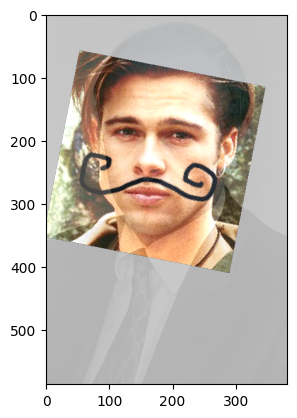

In [45]:
mask_back_as_mask = get_img('examples/masks/beard_back.png',mask=True)
mask_back_as_mask = add_alpha_channel(mask_back_as_mask)
out_alpha = add_alpha_channel(out)
warp_img_face = warp_im(out_alpha, transformation_matrix, target.shape)
#visualize the wrapped img on the original img
alpha = 0.3
beta = 1
result = cv2.addWeighted(target, alpha, warp_img_face, beta, 0)
overlay = cv2.add(target, warp_img_face)
plt.imshow(result)

In [50]:
out_mask_test = add_alpha_channel(out_mask)
out_mask_test.shape

(225, 225, 4)

frame: 0 Done


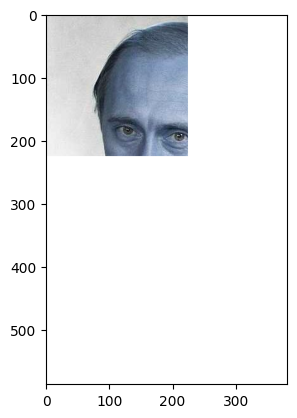

In [58]:
import numpy as np

def animate_face_swap(source, target, transformation_matrix, fps=30, duration=2):
    # Load the images
    source = source
    target = target

    # Get the dimensions of the target image
    height, width, _ = target.shape

    # Create a video writer to save the animation
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('face_swap_animation.mp4', fourcc, fps, (width, height))

    # Iterate through the transformation matrix to create the animation
    num_frames = int(fps * duration)
    for i in range(num_frames):
        # Interpolate the transformation matrix
        t = i / (num_frames)
        interp_matrix = (1 - t) * np.eye(3) + t * transformation_matrix

        # Apply the transformation to the source face mask
        transformed_mask = cv2.warpAffine(source[:, :, 3], interp_matrix[:2], (width, height))

        # Overlay the transformed mask on the target image
        target_with_mask = target.copy()
        target_with_mask[:, :, 3] = transformed_mask

        # Write the frame to the video
        out.write(target_with_mask.astype(np.uint8))
        plt.imshow(target_with_mask)
        print('frame:',i,'Done')
        break
    # Release the video writer
    out.release()

# Example usage



animate_face_swap(out_mask_test, target, transformation_matrix)

name 'warped_img_face' is not defined


Text(0.5, 1.0, 'Faces Overlaid')

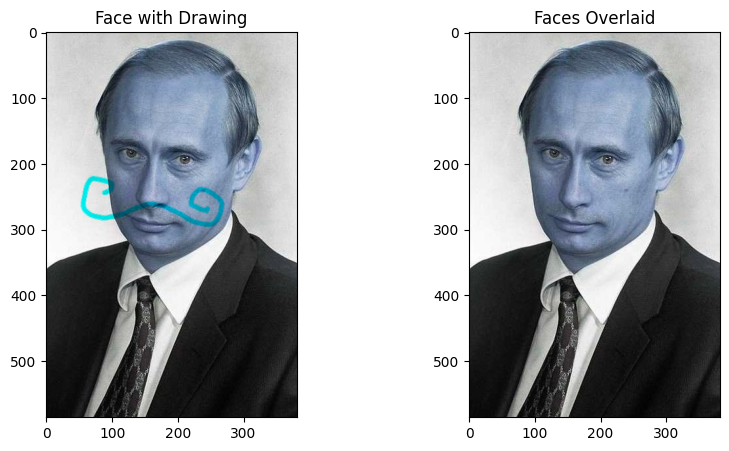

In [ ]:
out = img.copy()
out_face = img.copy()

wrapped_img = warp_im(mask_front, transformation_matrix, out.shape)
aligned_mask = wrapped_img



x_offset=y_offset=0
try:
    for c in range(0,3):
        out[0:out.shape[0],0:out.shape[1], c] =  aligned_mask[:,:,c] * (aligned_mask[:,:,3]/255.0) +  out[0:out.shape[0], 0:out.shape[1], c] * (1.0 - aligned_mask[:,:,3]/255.0)
        out_face[0:out_face.shape[0],0:out_face.shape[1], c] =  warped_img_face[:,:,c] * (warped_img_face[:,:,3]/255.0) +  out_face[0:out_face.shape[0], 0:out_face.shape[1], c] * (1.0 - warped_img_face[:,:,3]/255.0)
except Exception as e:
    print (e)
    pass

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(out)
plt.title('Face with Drawing')
plt.subplot(1, 2, 2)
plt.imshow(out_face)
plt.title('Faces Overlaid')


##Extract Frames from Videos

In [ ]:
#read an mp4 file and extract frames as images
VIDEO_PATH = "examples\\videos\\talking.mp4"
OUTPUT_DIR = "examples\\videos\\frames"
def extract_frames(video_path, output_dir, frame_interval=15):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    while success:
        if count % frame_interval == 0:  # Save every 'frame_interval' frame
            cv2.imwrite(f"{output_dir}/frame{count}.jpg", image)
        success, image = vidcap.read()
        count += 1

extract_frames(VIDEO_PATH, OUTPUT_DIR, frame_interval=1)






In [ ]:
# read folder OUTPUT_DIR and apply masks to each image
# and save the output to a new folder
# and then combine the frames to a video
import os
import glob

NEW_OUTPUT_DIR = "examples\\videos\\masked"

for file in glob.glob("examples\\videos\\frames\\*.jpg"):
    file_name = file.split('\\')[-1]
    img = get_img(file,)
    face = get_rects(img)
    if len(face) == 0:
        print ("no faces found in", file)
        cv2.imwrite(f"{NEW_OUTPUT_DIR}/{file_name}", img)
        continue

    mask_front =  get_img('examples\masks/beard_front.png',mask=True)
    mask_back = get_img('examples\masks/beard_back.png',mask = True)
    mask_face = get_rects(mask_back)[0]

    face = sort_faces_by_size(face)
    img = remove_alpha_channel(img)
    face_ldmks = get_landmarks(img, face[0])
    mask_ldmks = get_landmarks(mask_back, mask_face)


    img = add_alpha_channel(img)
    transformation_matrix = transformation_from_points(face_ldmks, mask_ldmks)

    out = img.copy()

    wrapped_img = warp_im(mask_front, transformation_matrix, out.shape)
    aligned_mask = wrapped_img



    x_offset=y_offset=0
    try:
        for c in range(0,3):
            out[0:out.shape[0],0:out.shape[1], c] =  aligned_mask[:,:,c] * (aligned_mask[:,:,3]/255.0) +  out[0:out.shape[0], 0:out.shape[1], c] * (1.0 - aligned_mask[:,:,3]/255.0)
    except Exception as e:
        print (e)
        pass

    cv2.imwrite(f"{NEW_OUTPUT_DIR}/{file_name}", out)
    print(f"Saved {NEW_OUTPUT_DIR}/{file_name}")

Saved examples\videos\masked/frame0.jpg
Saved examples\videos\masked/frame1.jpg
Saved examples\videos\masked/frame10.jpg
no faces found in examples\videos\frames\frame100.jpg
Saved examples\videos\masked/frame101.jpg
no faces found in examples\videos\frames\frame102.jpg
Saved examples\videos\masked/frame103.jpg
Saved examples\videos\masked/frame104.jpg
Saved examples\videos\masked/frame105.jpg
no faces found in examples\videos\frames\frame106.jpg
Saved examples\videos\masked/frame107.jpg
no faces found in examples\videos\frames\frame108.jpg
no faces found in examples\videos\frames\frame109.jpg
Saved examples\videos\masked/frame11.jpg
Saved examples\videos\masked/frame110.jpg
Saved examples\videos\masked/frame111.jpg
Saved examples\videos\masked/frame112.jpg
Saved examples\videos\masked/frame113.jpg
Saved examples\videos\masked/frame114.jpg
Saved examples\videos\masked/frame115.jpg
Saved examples\videos\masked/frame116.jpg
Saved examples\videos\masked/frame117.jpg
Saved examples\videos\

In [ ]:
import cv2
import os
VIDEO_OUTPUT_DIR = "examples\\videos\\outputs"
def frames_to_video(input_dir, output_video, fps):
    #images = sorted([img for img in os.listdir(input_dir) if img.endswith(".jpg")])
    images = sorted(os.listdir(input_dir), key=lambda img: int(img.split('frame')[1].split('.jpg')[0]))
    frame = cv2.imread(os.path.join(input_dir, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(input_dir, image)))

    cv2.destroyAllWindows()
    video.release()

frames_to_video(NEW_OUTPUT_DIR, VIDEO_OUTPUT_DIR+'/test_25.mp4', 25)

## Face Swapping

In [ ]:
def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im


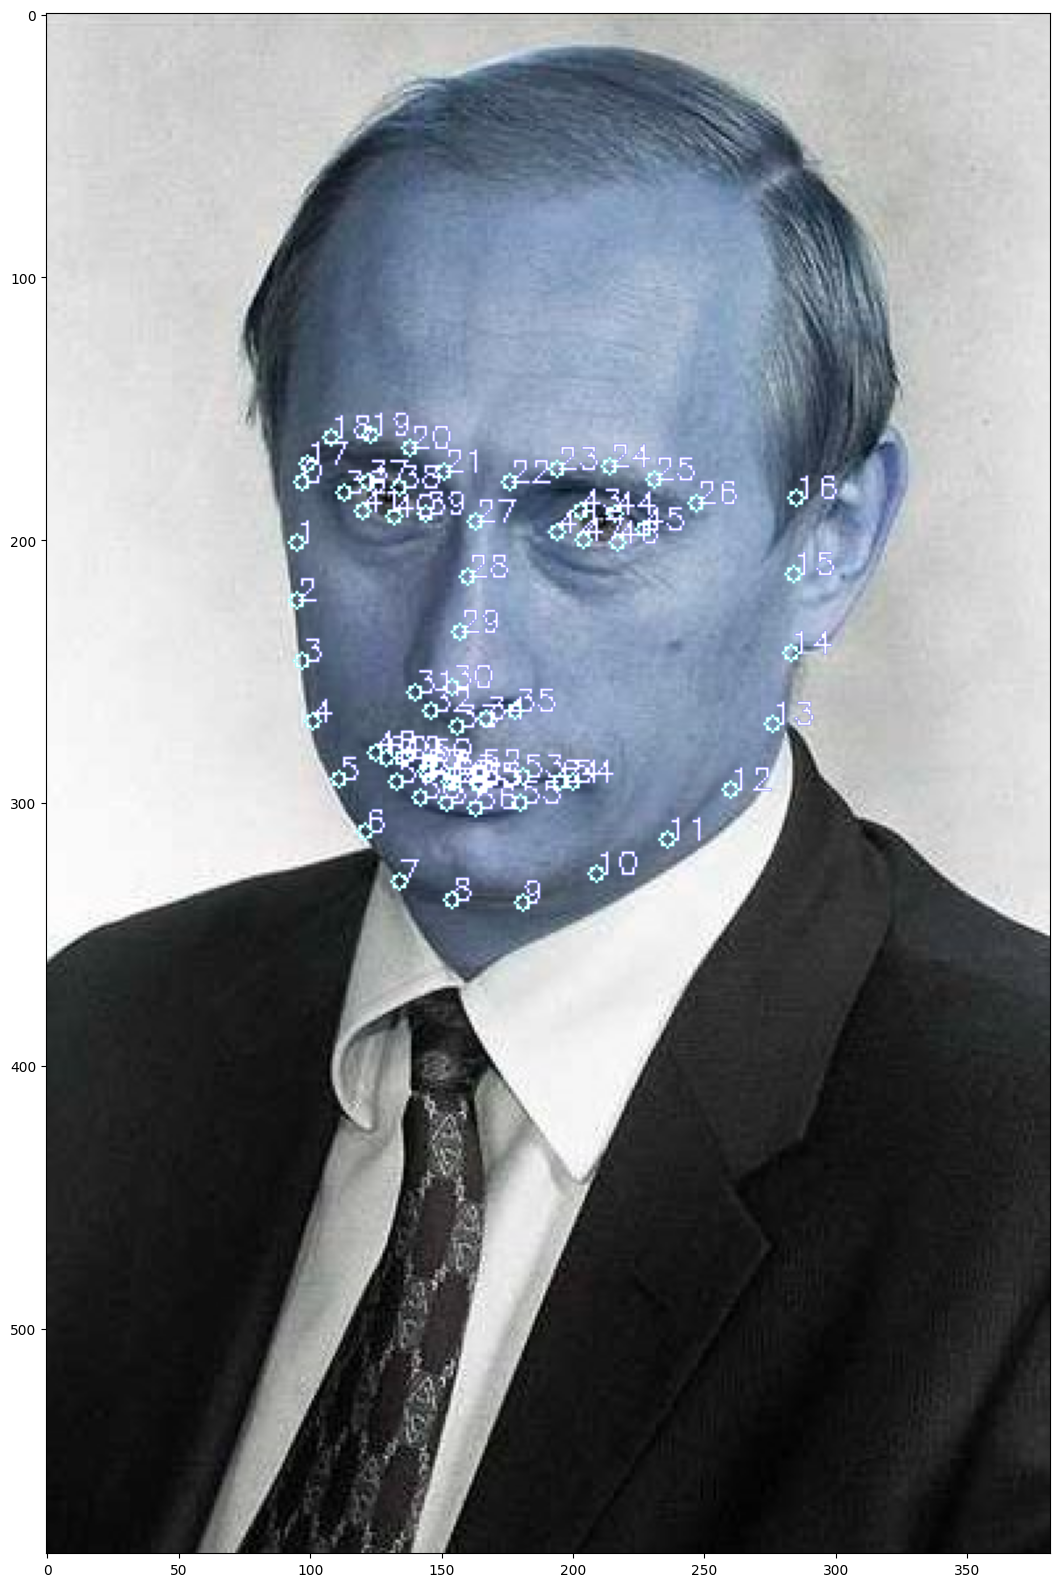

In [ ]:


img_marked = annotate_landmarks(img, face_ldmks)


#only show the face area
#face_area = img_marked[face[0].top():face[0].bottom()+20, face[0].left():face[0].right()]
plt.figure(figsize=(40, 20))
plt.imshow(img_marked)


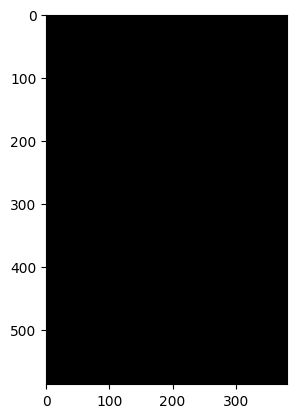

In [ ]:
import numpy
SCALE_FACTOR = 1
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.

#For Whole Face
"""OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]
"""

#For Left Half Face
OVERLAY_POINTS = [
    list(range(0, 9))+list(range(17, 22))+[27,30,8]
]




def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)


def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

#facial_mask = get_face_mask(aligned_mask, face_ldmks)
facial_mask = get_face_mask(warp_img_face, face_ldmks)
plt.imshow(facial_mask)

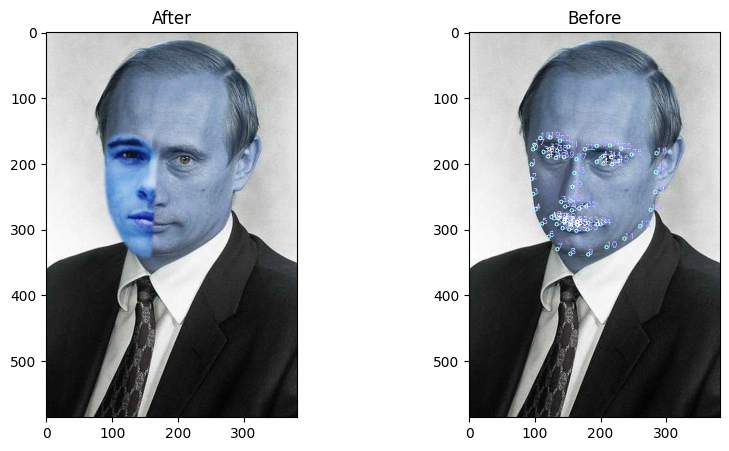

In [ ]:
# Apply the facial mask, where 0 is the mask and 1 is the face
out = img.copy()
for c in range(0,3):
    out[0:out.shape[0],0:out.shape[1], c] =  out[0:out.shape[0], 0:out.shape[1], c] * (1.0 - facial_mask[:,:,0]) +  warp_img_face[:,:,c] *facial_mask[:,:,0]
#plt.imshow(out)

plt.figure(figsize=(10, 5))  # Optional: Set the figure size

plt.subplot(1, 2, 1)  # Arguments are: (number of rows, number of columns, index of current plot)
plt.imshow(out)
plt.title('After')  # Optional: Set the title for the plot

plt.subplot(1, 2, 2)
plt.imshow(img_marked)
plt.title('Before')  # Optional: Set the title for the plot

plt.show()

In [ ]:

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

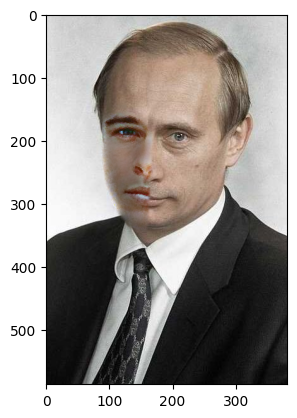

In [ ]:
imgcopy = img.copy()
warped_img = warp_img_face.copy()
warped_corrected_im2 = correct_colours(imgcopy, warped_img, face_ldmks)
facial_mask_2 = get_face_mask(imgcopy, face_ldmks)
facial_mask_2 = add_alpha_channel(facial_mask_2)


output_im = imgcopy * (1.0 - facial_mask_2) + warped_corrected_im2 * facial_mask_2
output_im = output_im.astype(np.uint8)
output_im = cv2.cvtColor(output_im, cv2.COLOR_BGR2RGB)
plt.imshow(output_im)


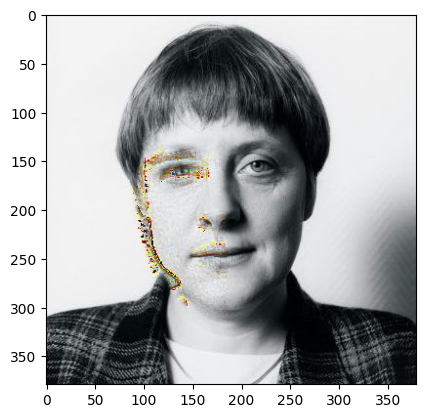

In [ ]:

#cv2.imwrite('outputggg.jpg', output_im)
